In [1]:
from hllhc_rematch_tools import *
import os
import matplotlib.pyplot as plt

%matplotlib inline

/home/yannis/miniforge/lib/python3.10/site-packages/xtrack/progress_indicator.py:95: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
get_ipython().run_line_magic("load_ext", "autoreload")
get_ipython().run_line_magic("autoreload", "2")


In [3]:
default_tol = {None: 1e-8, 'betx': 1e-6, 'bety': 1e-6}

In [4]:
# optics_name = "opt/opt_collapse_1100_1500.madx"
optics_name = "opt/opt_round_150_1500.madx"

collider = None
collider_name = "collider_hl16.json"
if os.path.exists(collider_name):
    collider = xt.Multiline.from_json(collider_name)
else:
    collider = build_collider(optics_name, cycling=False)
    collider.to_json(collider_name)

collider.vars.load_madx_optics_file(optics_name)

Loading line from dict: 100%|██████████| 30815/30815 [00:01<00:00, 27187.57it/s]


Done loading line from dict.           


Loading line from dict: 100%|██████████| 30855/30855 [00:01<00:00, 27101.37it/s]


Done loading line from dict.           


In [5]:
tw = collider.twiss()

print(tw["lhcb1"][["betx", "bety"], "ip.*"])
print(tw["lhcb2"][["betx", "bety"], "ip.*"])

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
TwissTable: 9 rows, 3 cols
name                        betx    bety
ip1                         0.15    0.15
ip2                           10      10
ip3                       121.57 218.624
ip4                      236.184 306.285
ip5                         0.15    0.15
ip6                      273.429 183.792
ip7                      120.808 149.406
ip8                          1.5     1.5
ip1.l1                      0.15    0.15
TwissTable: 9 rows, 3 cols
name                        betx    bety
ip1                         0.15    0.15
ip2                           10      10
ip3                      121.567 218.519
ip4                      236.152 320.918
ip5                         0.15    0.15
ip6                      188.452 144.613
ip7                  

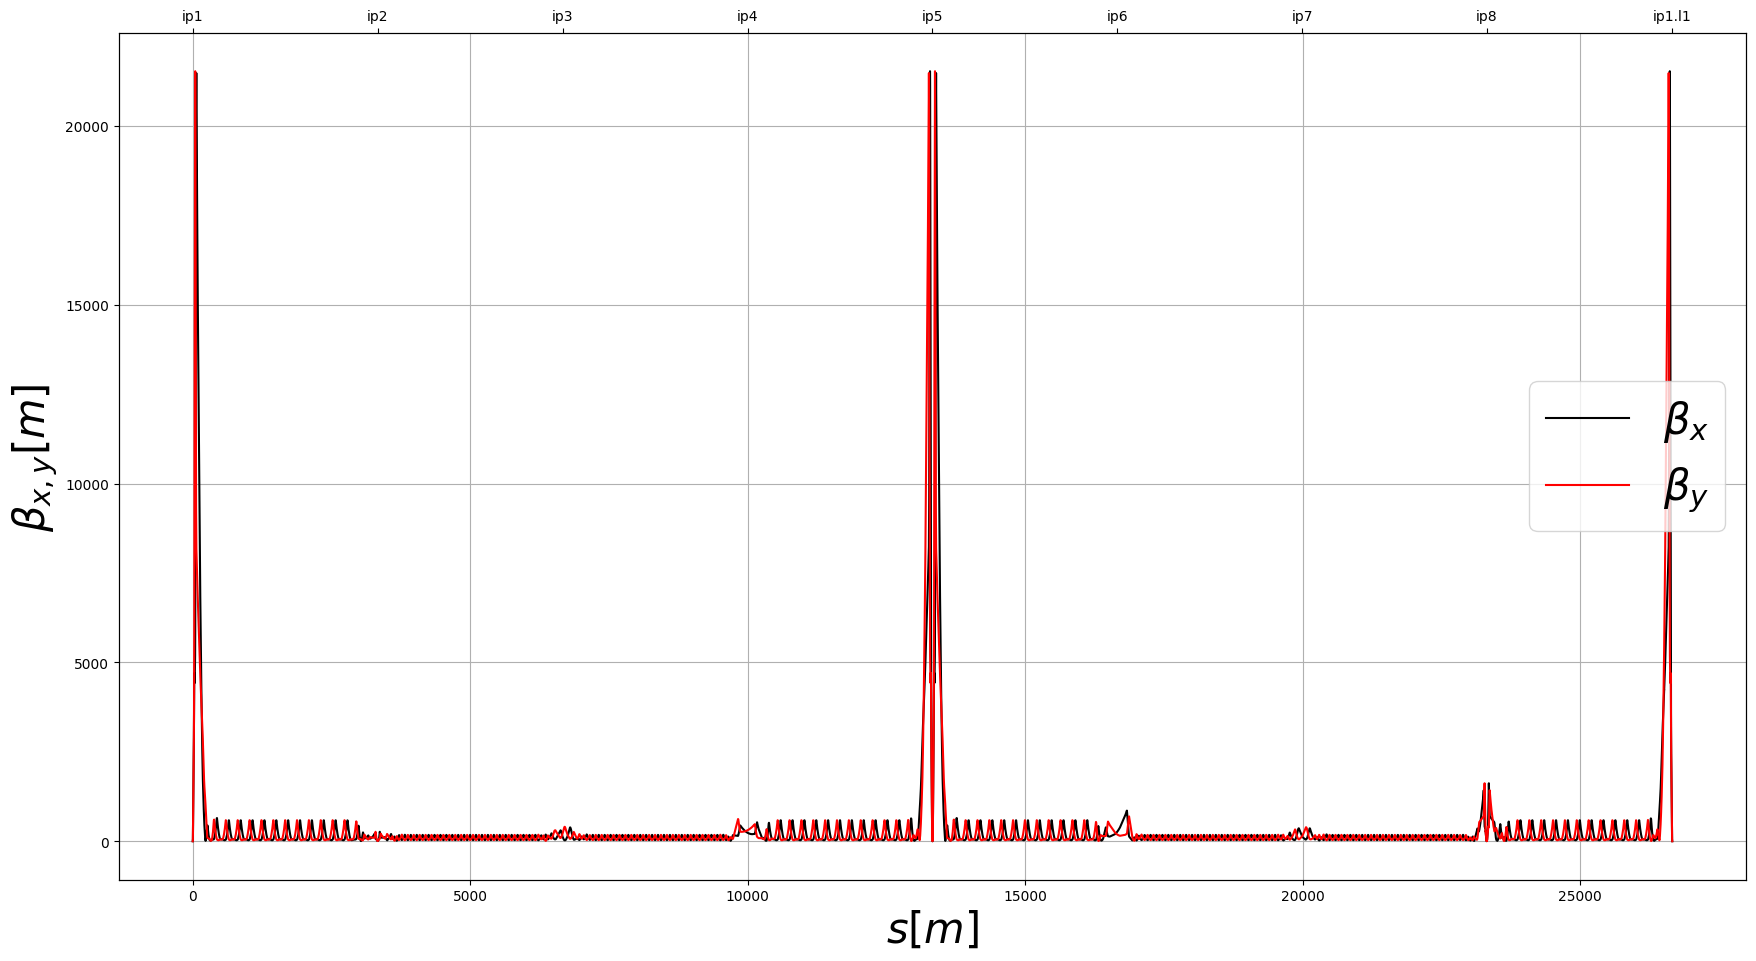

In [6]:
fig, axs = plt.subplots(figsize=(21, 11))
axs.plot(tw["lhcb1"].s, tw["lhcb1"].betx, label=r"$\beta_x$", color="black")
axs.plot(tw["lhcb1"].s, tw["lhcb1"].bety, label=r"$\beta_y$", color="red")
axs_t = axs.twiny()
axs_t.set_xticks(
    tw["lhcb1"][["s"], "ip.*"], tw["lhcb1"][["name"], "ip.*"], rotation="horizontal"
)
axs_t.set_xlim(axs.get_xlim()[0], axs.get_xlim()[1])
axs.set_ylabel(r"$\beta_{x,y} [m]$", fontsize=30)
axs.set_xlabel(r"$s [m]$", fontsize=30)
axs.legend(fontsize=30)
axs.grid()
plt.show()

In [7]:
staged_match = True

In [8]:
betx0_ip1 = 0.5
bety0_ip1 = 0.5
betx0_ip5 = 0.5
bety0_ip5 = 0.5

betx_ip1 = 0.15
bety_ip1 = 0.15
betx_ip5 = 0.15
bety_ip5 = 0.15

In [9]:
lm.set_var_limits_and_steps(collider)

set_var_limits_and_steps_orbit_ip15(collider) # correctors for orbit in 1,5
set_var_limits_and_steps_quads_ip15(collider) # quads in 1,5
set_var_limits_and_steps_sextupoles_w(collider) # for chromatic functions
set_var_limits_and_steps_ksf_ksd(collider)
set_var_limits_and_steps_disp_correctors(collider)
set_var_limits_and_steps_ahvcrab(collider)

In [10]:
muxs = {}
muys = {}

saved_vars = {}
saved_vars.update(
    {
        "b1": {"ip2": {}, "ip3": {}, "ip4": {}, "ip6": {}, "ip7": {}, "ip8": {}},
        "b2": {"ip2": {}, "ip3": {}, "ip4": {}, "ip6": {}, "ip7": {}, "ip8": {}},
    }
)

for bim in ["b1", "b2"]:
    for arc_name in lm.ARC_NAMES:
        muxs[f"mux{arc_name}{bim}"] = collider.varval[f"mux{arc_name}{bim}"]
        muys[f"muy{arc_name}{bim}"] = collider.varval[f"muy{arc_name}{bim}"]
    for ip_name in [2, 4, 6, 8]:
        muxs[f"muxip{ip_name}{bim}"] = collider.varval[f"muxip{ip_name}{bim}"]
        muys[f"muyip{ip_name}{bim}"] = collider.varval[f"muyip{ip_name}{bim}"]
    for ip_name in [1, 5]:
        muxs[f"muxip{ip_name}{bim}_l"] = collider.varval[f"muxip{ip_name}{bim}_l"]
        muys[f"muyip{ip_name}{bim}_l"] = collider.varval[f"muyip{ip_name}{bim}_l"]
        muxs[f"muxip{ip_name}{bim}_r"] = collider.varval[f"muxip{ip_name}{bim}_r"]
        muys[f"muyip{ip_name}{bim}_r"] = collider.varval[f"muyip{ip_name}{bim}_r"]

    saved_vars[bim]["ip2"]["betx"] = collider.varval[f"betxip2{bim}"]
    saved_vars[bim]["ip2"]["bety"] = collider.varval[f"betyip2{bim}"]

    for ip_name in [3, 7]:
        for param in ["betx", "bety", "alfx", "alfy", "dx", "dpx", "mux", "muy"]:
            saved_vars[bim][f"ip{ip_name}"][param] = collider.varval[
                f"{param}ip{ip_name}{bim}"
            ]

    for ip_name in [4, 6, 8]:
        for param in ["betx", "bety", "alfx", "alfy", "dx", "dpx"]:
            saved_vars[bim][f"ip{ip_name}"][param] = collider.varval[
                f"{param}ip{ip_name}{bim}"
            ]


In [11]:
tw45_56_xt = lm.get_arc_periodic_solution(collider, arc_name=["45", "56"])
tw81_12_xt = lm.get_arc_periodic_solution(collider, arc_name=["81", "12"])


Found suitable prebuilt kernel `only_xtrack_backtrack_frozen_energy`.
Found suitable prebuilt kernel `only_xtrack_backtrack_frozen_energy`.


Presquezze twiss to check with the new matched optics

In [13]:
beta0 = tw45_56_xt["lhcb1"]["45"].get_twiss_init("s.ds.l5.b1")
beta0.mux = 0
beta0.muy = 0
tw_ip5 = collider.lhcb1.twiss(
    start="s.ds.l5.b1", end="e.ds.r5.b1", init=beta0
)
beta0 = tw81_12_xt["lhcb1"]["81"].get_twiss_init("s.ds.l1.b1")
beta0.mux = 0
beta0.muy = 0
tw_ip1 = collider.lhcb1.cycle("ip3").twiss(
    start="s.ds.l1.b1", end="e.ds.r1.b1", init=beta0, method="4d"
)

In [14]:
print(tw_ip1[["betx", "bety"], "ip.*"])
print(tw_ip5[["betx", "bety"], "ip.*"])

TwissTable: 2 rows, 3 cols
name                   betx bety
ip1.l1                  0.5  0.5
ip1                     0.5  0.5
TwissTable: 1 row, 3 cols
name                   betx bety
ip5                     0.5  0.5


In [15]:
optimizers = {}

Changing limits for the triplet if needed (default is set up as 90%)

In [16]:
# collider.vars.vary_default.update(
#     {
#         "kqx1.l1": {"step": 1e-6, "limits": (-qtlim1, -qtlim1 * 0.91)},
#         "kqx2a.l1": {"step": 1e-6, "limits": (-qtlim1, -qtlim1 * 0.91)},
#         "kqx3.l1": {"step": 1e-6, "limits": (-qtlim1, -qtlim1 * 0.91)},
#     }
# )

In [17]:
optimizers["ir15"] = rematch_ir15(
    collider,
    betx0_ip5,
    bety0_ip5,
    tw_sq_a45_ip5_a56=tw45_56_xt,
    restore=False,
    ir5q4sym=0,
    ir5q5sym=0,
    ir5q6sym=0,
    solve=True,
    match_on_triplet=0,
    default_tol=default_tol,
)

Matching: model call n. 1       



In [18]:
print(optimizers["ir15"].target_status())
print(optimizers["ir15"].log())

Target status:                  
id state tag tol_met      residue  current_val target_val description                                 
 0 ON           True  4.67609e-11          0.5        0.5 line=lhcb1, ('betx', 'ip5'), val=0.5, to ...
 1 ON           True  2.38513e-10          0.5        0.5 line=lhcb1, ('bety', 'ip5'), val=0.5, to ...
 2 ON           True  8.94933e-12  8.94933e-12          0 line=lhcb1, ('alfx', 'ip5'), val=0, tol= ...
 3 ON           True  6.93529e-11  6.93529e-11          0 line=lhcb1, ('alfy', 'ip5'), val=0, tol= ...
 4 ON           True -8.40497e-11 -8.40497e-11          0 line=lhcb1, ('dx', 'ip5'), val=0, tol=1e ...
 5 ON           True -2.57776e-10 -2.57776e-10          0 line=lhcb1, ('dpx', 'ip5'), val=0, tol=1 ...
 6 ON           True  5.92865e-11          0.5        0.5 line=lhcb2, ('betx', 'ip5'), val=0.5, to ...
 7 ON           True  3.72439e-11          0.5        0.5 line=lhcb2, ('bety', 'ip5'), val=0.5, to ...
 8 ON           True  7.80452e-11  7.804

In [19]:
optimizers["ir15_run2"] = rematch_ir15(
    collider,
    betx0_ip5,
    bety0_ip5,
    tw_sq_a45_ip5_a56=tw45_56_xt,
    restore=False,
    ir5q4sym=0,
    ir5q5sym=0,
    ir5q6sym=0,
    solve=True,
    match_on_triplet=0,
    default_tol=default_tol,
)


Matching: model call n. 1       



In [20]:
print(optimizers["ir15_run2"].target_status())
print(optimizers["ir15_run2"].log())


Target status:                  
id state tag tol_met      residue  current_val target_val description                                 
 0 ON           True  4.67609e-11          0.5        0.5 line=lhcb1, ('betx', 'ip5'), val=0.5, to ...
 1 ON           True  2.38513e-10          0.5        0.5 line=lhcb1, ('bety', 'ip5'), val=0.5, to ...
 2 ON           True  8.94933e-12  8.94933e-12          0 line=lhcb1, ('alfx', 'ip5'), val=0, tol= ...
 3 ON           True  6.93529e-11  6.93529e-11          0 line=lhcb1, ('alfy', 'ip5'), val=0, tol= ...
 4 ON           True -8.40497e-11 -8.40497e-11          0 line=lhcb1, ('dx', 'ip5'), val=0, tol=1e ...
 5 ON           True -2.57776e-10 -2.57776e-10          0 line=lhcb1, ('dpx', 'ip5'), val=0, tol=1 ...
 6 ON           True  5.92865e-11          0.5        0.5 line=lhcb2, ('betx', 'ip5'), val=0.5, to ...
 7 ON           True  3.72439e-11          0.5        0.5 line=lhcb2, ('bety', 'ip5'), val=0.5, to ...
 8 ON           True  7.80452e-11  7.804

In [21]:
optimizers["ir15_run3"] = rematch_ir15(
    collider,
    betx0_ip5,
    bety0_ip5,
    tw_sq_a45_ip5_a56=tw45_56_xt,
    restore=False,
    ir5q4sym=0,
    ir5q5sym=0,
    ir5q6sym=0,
    solve=True,
    match_on_triplet=0,
    default_tol=default_tol,
)

Matching: model call n. 1       



In [22]:
print(optimizers["ir15_run3"].target_status())
print(optimizers["ir15_run3"].log())

Target status:                  
id state tag tol_met      residue  current_val target_val description                                 
 0 ON           True  4.67609e-11          0.5        0.5 line=lhcb1, ('betx', 'ip5'), val=0.5, to ...
 1 ON           True  2.38513e-10          0.5        0.5 line=lhcb1, ('bety', 'ip5'), val=0.5, to ...
 2 ON           True  8.94933e-12  8.94933e-12          0 line=lhcb1, ('alfx', 'ip5'), val=0, tol= ...
 3 ON           True  6.93529e-11  6.93529e-11          0 line=lhcb1, ('alfy', 'ip5'), val=0, tol= ...
 4 ON           True -8.40497e-11 -8.40497e-11          0 line=lhcb1, ('dx', 'ip5'), val=0, tol=1e ...
 5 ON           True -2.57776e-10 -2.57776e-10          0 line=lhcb1, ('dpx', 'ip5'), val=0, tol=1 ...
 6 ON           True  5.92865e-11          0.5        0.5 line=lhcb2, ('betx', 'ip5'), val=0.5, to ...
 7 ON           True  3.72439e-11          0.5        0.5 line=lhcb2, ('bety', 'ip5'), val=0.5, to ...
 8 ON           True  7.80452e-11  7.804

In [23]:
tw81_45_new = lm.get_arc_periodic_solution(collider, arc_name=["81", "45"])

beta0 = tw81_45_new["lhcb1"]["45"].get_twiss_init("s.ds.l5.b1")
beta0.mux = 0
beta0.muy = 0
tw_ip5_new = collider.lhcb1.twiss(
    start="s.ds.l5.b1", end="e.ds.r5.b1", init=beta0
)


beta0 = tw81_45_new["lhcb1"]["81"].get_twiss_init("s.ds.l1.b1")
beta0.mux = 0
beta0.muy = 0
tw_ip1_new = collider.lhcb1.cycle("ip3").twiss(
    start="s.ds.l1.b1", end="e.ds.r1.b1", init=beta0
)


In [24]:
print(tw_ip5_new[["betx", "bety"], "ip5"])
print(tw_ip1_new[["betx", "bety"], "ip1"])

TwissTable: 1 row, 3 cols
name                   betx bety
ip5                     0.5  0.5
TwissTable: 1 row, 3 cols
name                   betx bety
ip1                     0.5  0.5


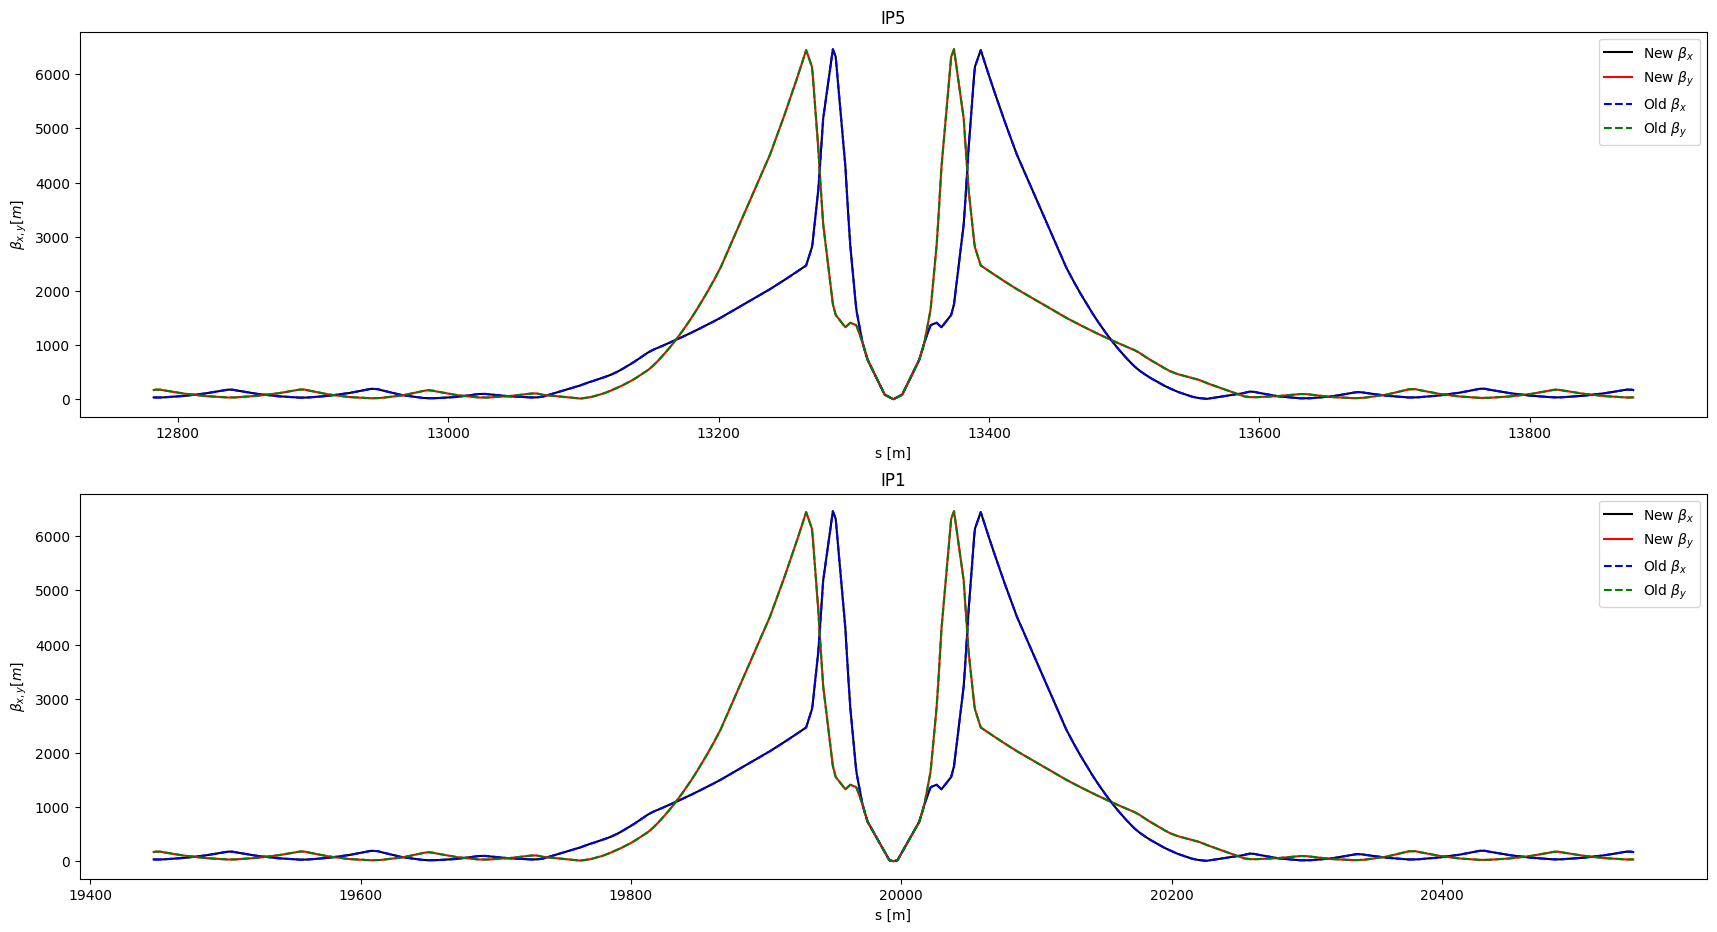

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(21, 11))
axs[0].set_title("IP5")
axs[0].plot(tw_ip5_new.s, tw_ip5_new.betx, color="black", label=r"New $\beta_x$")
axs[0].plot(tw_ip5_new.s, tw_ip5_new.bety, color="red", label=r"New $\beta_y$")
axs[0].plot(tw_ip5.s, tw_ip5.betx, ls="--", color="blue", label=r"Old $\beta_x$")
axs[0].plot(tw_ip5.s, tw_ip5.bety, ls="--", color="green", label=r"Old $\beta_y$")

axs[0].set_xlabel("s [m]")
axs[0].set_ylabel(r"$\beta_{x,y} [m]$")
axs[0].legend()

axs[1].set_title("IP1")
axs[1].plot(tw_ip1_new.s, tw_ip1_new.betx, color="black", label=r"New $\beta_x$")
axs[1].plot(tw_ip1_new.s, tw_ip1_new.bety, color="red", label=r"New $\beta_y$")
axs[1].plot(tw_ip1.s, tw_ip1.betx, ls="--", color="blue", label=r"Old $\beta_x$")
axs[1].plot(tw_ip1.s, tw_ip1.bety, ls="--", color="green", label=r"Old $\beta_y$")

axs[1].set_xlabel("s [m]")
axs[1].set_ylabel(r"$\beta_{x,y} [m]$")
axs[1].legend()


plt.show()

In [26]:
tw_non_ats_arcs = lm.get_arc_periodic_solution(collider, arc_name=["23", "34", "67", "78"])

In [27]:
for bim in ["b1", "b2"]:
    optimizers[f"ir3{bim}"] = lm.rematch_ir3(
        collider=collider,
        line_name=f"lhc{bim}",
        boundary_conditions_left=tw_non_ats_arcs[f"lhc{bim}"]["23"],
        boundary_conditions_right=tw_non_ats_arcs[f"lhc{bim}"]["34"],
        mux_ir3=saved_vars[bim]["ip3"]["mux"],
        muy_ir3=saved_vars[bim]["ip3"]["muy"],
        alfx_ip3=saved_vars[bim]["ip3"]["alfx"],
        alfy_ip3=saved_vars[bim]["ip3"]["alfy"],
        betx_ip3=saved_vars[bim]["ip3"]["betx"],
        bety_ip3=saved_vars[bim]["ip3"]["bety"],
        dx_ip3=saved_vars[bim]["ip3"]["dx"],
        dpx_ip3=saved_vars[bim]["ip3"]["dpx"],
        solve=True,
        staged_match=True,
        default_tol=default_tol,
    )

Matching: model call n. 1       

Matching: model call n. 2       

Matching: model call n. 1       

Matching: model call n. 2       



In [28]:
optimizers["ir3b1"].target_status()
optimizers["ir3b2"].target_status()

print(optimizers["ir3b1"].log())
print(optimizers["ir3b2"].log())

Target status:                  
id state tag    tol_met      residue current_val target_val description                                 
 0 ON    stage1    True -8.03988e-09      121.57     121.57 line=lhcb1, ('betx', 'ip3'), val=121.57, ...
 1 ON    stage1    True -1.28866e-08     218.624    218.624 line=lhcb1, ('bety', 'ip3'), val=218.624 ...
 2 ON    stage1    True -2.82034e-10     2.29579    2.29579 line=lhcb1, ('alfx', 'ip3'), val=2.29579 ...
 3 ON    stage1    True  3.44511e-10    -2.64314   -2.64315 line=lhcb1, ('alfy', 'ip3'), val=-2.6431 ...
 4 ON    stage1    True  4.43814e-09   -0.510534  -0.510534 line=lhcb1, ('dx', 'ip3'), val=-0.510534 ...
 5 ON    stage1    True   4.9026e-11   -0.006524  -0.006524 line=lhcb1, ('dpx', 'ip3'), val=-0.00652 ...
 6 ON              True  -2.5802e-08     169.606    169.606 line=lhcb1, ('betx', 'e.ds.r3.b1'), val= ...
 7 ON              True  6.43371e-09     33.8055    33.8055 line=lhcb1, ('bety', 'e.ds.r3.b1'), val= ...
 8 ON              Tru

In [29]:
for bim in ["b1", "b2"]:
    optimizers[f"ir7{bim}"] = lm.rematch_ir7(
        collider=collider,
        line_name=f"lhc{bim}",
        boundary_conditions_left=tw_non_ats_arcs[f"lhc{bim}"]["67"],
        boundary_conditions_right=tw_non_ats_arcs[f"lhc{bim}"]["78"],
        mux_ir7=saved_vars[bim]["ip7"]["mux"],
        muy_ir7=saved_vars[bim]["ip7"]["muy"],
        alfx_ip7=saved_vars[bim]["ip7"]["alfx"],
        alfy_ip7=saved_vars[bim]["ip7"]["alfy"],
        betx_ip7=saved_vars[bim]["ip7"]["betx"],
        bety_ip7=saved_vars[bim]["ip7"]["bety"],
        dx_ip7=saved_vars[bim]["ip7"]["dx"],
        dpx_ip7=saved_vars[bim]["ip7"]["dpx"],
        solve=True,
        staged_match=True,
        default_tol=default_tol,
    )


Matching: model call n. 1       

Matching: model call n. 2       

Matching: model call n. 1       

Matching: model call n. 2       



In [30]:
optimizers["ir7b1"].target_status()
optimizers["ir7b2"].target_status()

print(optimizers["ir7b1"].log())
print(optimizers["ir7b2"].log())

Target status:                  
id state tag    tol_met      residue current_val target_val description                                 
 0 ON    stage1    True  1.87646e-08     120.808    120.808 line=lhcb1, ('betx', 'ip7'), val=120.808 ...
 1 ON    stage1    True  2.67987e-08     149.406    149.406 line=lhcb1, ('bety', 'ip7'), val=149.406 ...
 2 ON    stage1    True  1.83096e-10     1.27699    1.27699 line=lhcb1, ('alfx', 'ip7'), val=1.27699 ...
 3 ON    stage1    True   -1.653e-10    -1.38498   -1.38498 line=lhcb1, ('alfy', 'ip7'), val=-1.3849 ...
 4 ON    stage1    True  1.88951e-09   -0.203782  -0.203782 line=lhcb1, ('dx', 'ip7'), val=-0.203782 ...
 5 ON    stage1    True  8.49101e-12 8.49101e-12         -0 line=lhcb1, ('dpx', 'ip7'), val=-0, tol= ...
 6 ON              True -4.94397e-08     168.774    168.774 line=lhcb1, ('betx', 'e.ds.r7.b1'), val= ...
 7 ON              True  6.80491e-09     33.8694    33.8694 line=lhcb1, ('bety', 'e.ds.r7.b1'), val= ...
 8 ON              Tru

In [31]:
twb1 = collider["lhcb1"].cycle("ip3").twiss(method="4d")
twb2 = collider["lhcb2"].cycle("ip3").twiss(method="4d")

In [32]:
print(twb1[["betx", "bety"], "ip.*"])
print(twb2[["betx", "bety"], "ip.*"])

TwissTable: 9 rows, 3 cols
name                        betx    bety
ip3                       121.57 218.624
ip4                      236.184 306.285
ip5                         0.15    0.15
ip6                      273.429 183.792
ip7                      120.808 149.406
ip8                          1.5     1.5
ip1.l1                      0.15    0.15
ip1                         0.15    0.15
ip2                           10      10
TwissTable: 9 rows, 3 cols
name                        betx    bety
ip3                      121.567 218.519
ip2                           10      10
ip1                         0.15    0.15
ip1.l1                      0.15    0.15
ip8                          1.5     1.5
ip7                      120.809 149.405
ip6                      188.452 144.613
ip5                         0.15    0.15
ip4                      236.152 320.918


In [33]:
tw_sq_a81_ip1_a12_b1 = lm.propagate_optics_from_beta_star(
    collider,
    ip_name="ip1",
    line_name="lhcb1",
    start="s.ds.r8.b1",
    end="e.ds.l2.b1",
    beta_star_x=betx_ip1,
    beta_star_y=bety_ip1,
)

tw_sq_a45_ip5_a56_b1 = lm.propagate_optics_from_beta_star(
    collider,
    ip_name="ip5",
    line_name="lhcb1",
    start="s.ds.r4.b1",
    end="e.ds.l6.b1",
    beta_star_x=betx_ip5,
    beta_star_y=bety_ip5,
)

tw_sq_a81_ip1_a12_b2 = lm.propagate_optics_from_beta_star(
    collider,
    ip_name="ip1",
    line_name="lhcb2",
    start="s.ds.r8.b2",
    end="e.ds.l2.b2",
    beta_star_x=betx_ip1,
    beta_star_y=bety_ip1,
)

tw_sq_a45_ip5_a56_b2 = lm.propagate_optics_from_beta_star(
    collider,
    ip_name="ip5",
    line_name="lhcb2",
    start="s.ds.r4.b2",
    end="e.ds.l6.b2",
    beta_star_x=betx_ip5,
    beta_star_y=bety_ip5,
)

Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.


In [34]:
(
    mux_ir2_target_b1,
    muy_ir2_target_b1,
    mux_ir4_target_b1,
    muy_ir4_target_b1,
    mux_ir6_target_b1,
    muy_ir6_target_b1,
    mux_ir8_target_b1,
    muy_ir8_target_b1,
) = lm.compute_ats_phase_advances_for_auxiliary_irs(
    "lhcb1",
    tw_sq_a81_ip1_a12_b1,
    tw_sq_a45_ip5_a56_b1,
    muxs["muxip1b1_l"],
    muys["muyip1b1_l"],
    muxs["muxip1b1_r"],
    muys["muyip1b1_r"],
    muxs["muxip5b1_l"],
    muys["muyip5b1_l"],
    muxs["muxip5b1_r"],
    muys["muyip5b1_r"],
    muxs["muxip2b1"],
    muys["muyip2b1"],
    muxs["muxip4b1"],
    muys["muyip4b1"],
    muxs["muxip6b1"],
    muys["muyip6b1"],
    muxs["muxip8b1"],
    muys["muyip8b1"],
    muxs["mux12b1"],
    muys["muy12b1"],
    muxs["mux45b1"],
    muys["muy45b1"],
    muxs["mux56b1"],
    muys["muy56b1"],
    muxs["mux81b1"],
    muys["muy81b1"],
)

(
    mux_ir2_target_b2,
    muy_ir2_target_b2,
    mux_ir4_target_b2,
    muy_ir4_target_b2,
    mux_ir6_target_b2,
    muy_ir6_target_b2,
    mux_ir8_target_b2,
    muy_ir8_target_b2,
) = lm.compute_ats_phase_advances_for_auxiliary_irs(
    "lhcb2",
    tw_sq_a81_ip1_a12_b2,
    tw_sq_a45_ip5_a56_b2,
    muxs["muxip1b2_l"],
    muys["muyip1b2_l"],
    muxs["muxip1b2_r"],
    muys["muyip1b2_r"],
    muxs["muxip5b2_l"],
    muys["muyip5b2_l"],
    muxs["muxip5b2_r"],
    muys["muyip5b2_r"],
    muxs["muxip2b2"],
    muys["muyip2b2"],
    muxs["muxip4b2"],
    muys["muyip4b2"],
    muxs["muxip6b2"],
    muys["muyip6b2"],
    muxs["muxip8b2"],
    muys["muyip8b2"],
    muxs["mux12b2"],
    muys["muy12b2"],
    muxs["mux45b2"],
    muys["muy45b2"],
    muxs["mux56b2"],
    muys["muy56b2"],
    muxs["mux81b2"],
    muys["muy81b2"],
)

In [36]:
optimizers["ir2b1"] = lm.rematch_ir2(
    collider,
    line_name="lhcb1",
    boundary_conditions_left=tw_sq_a81_ip1_a12_b1,
    boundary_conditions_right=tw_non_ats_arcs["lhcb1"]["23"],
    mux_ir2=mux_ir2_target_b1,
    muy_ir2=muy_ir2_target_b1,
    betx_ip2=saved_vars["b1"]["ip2"]["betx"],
    bety_ip2=saved_vars["b1"]["ip2"]["bety"],
    solve=True,
    staged_match=staged_match,
    default_tol=default_tol,
)


optimizers["ir2b2"] = lm.rematch_ir2(
    collider,
    line_name="lhcb2",
    boundary_conditions_left=tw_sq_a81_ip1_a12_b2,
    boundary_conditions_right=tw_non_ats_arcs["lhcb2"]["23"],
    mux_ir2=mux_ir2_target_b2,
    muy_ir2=muy_ir2_target_b2,
    betx_ip2=saved_vars["b2"]["ip2"]["betx"],
    bety_ip2=saved_vars["b2"]["ip2"]["bety"],
    solve=True,
    staged_match=staged_match,
    default_tol=default_tol,
)


Matching: model call n. 1       

Matching: model call n. 2       





Matching: model call n. 1       

Matching: model call n. 2       

Matching: model call n. 3       



In [37]:
optimizers["ir2b1"].target_status()
optimizers["ir2b2"].target_status()

print(optimizers["ir2b1"].log())
print(optimizers["ir2b2"].log())

Target status:                  
id state tag    tol_met      residue  current_val target_val description                                 
 0 ON    stage0    True  2.53953e-08      33.5254    33.5254 line=lhcb1, ('betx', 'e.ds.r2.b1'), val= ...
 1 ON    stage0    True  1.50025e-07      169.749    169.749 line=lhcb1, ('bety', 'e.ds.r2.b1'), val= ...
 2 ON    stage0    True  5.57767e-10    -0.541734  -0.541734 line=lhcb1, ('alfx', 'e.ds.r2.b1'), val= ...
 3 ON    stage0    True  1.39182e-09      2.34896    2.34896 line=lhcb1, ('alfy', 'e.ds.r2.b1'), val= ...
 4 ON    stage0    True -5.73989e-10      1.08238    1.08238 line=lhcb1, ('dx', 'e.ds.r2.b1'), val=1. ...
 5 ON    stage0    True  9.83504e-11    0.0142157  0.0142157 line=lhcb1, ('dpx', 'e.ds.r2.b1'), val=0 ...
 6 ON    stage2    True  5.60235e-10           10         10 line=lhcb1, ('betx', 'ip2'), val=10, tol ...
 7 ON    stage2    True  8.14143e-09           10         10 line=lhcb1, ('bety', 'ip2'), val=10, tol ...
 8 ON    stag

In [38]:
optimizers["ir8b1"] = lm.rematch_ir8(
    collider,
    line_name="lhcb1",
    boundary_conditions_left=tw_non_ats_arcs["lhcb1"]["78"],
    boundary_conditions_right=tw_sq_a81_ip1_a12_b1,
    solve=True,
    mux_ir8=mux_ir8_target_b1,
    muy_ir8=muy_ir8_target_b1,
    alfx_ip8=saved_vars["b1"]["ip8"]["alfx"],
    alfy_ip8=saved_vars["b1"]["ip8"]["alfy"],
    betx_ip8=saved_vars["b1"]["ip8"]["betx"],
    bety_ip8=saved_vars["b1"]["ip8"]["bety"],
    dx_ip8=saved_vars["b1"]["ip8"]["dx"],
    dpx_ip8=saved_vars["b1"]["ip8"]["dpx"],
    staged_match=staged_match,
    default_tol=default_tol,
)

optimizers["ir8b2"] = lm.rematch_ir8(
    collider,
    line_name="lhcb2",
    boundary_conditions_left=tw_non_ats_arcs["lhcb2"]["78"],
    boundary_conditions_right=tw_sq_a81_ip1_a12_b2,
    solve=True,
    mux_ir8=mux_ir8_target_b2,
    muy_ir8=muy_ir8_target_b2,
    alfx_ip8=saved_vars["b2"]["ip8"]["alfx"],
    alfy_ip8=saved_vars["b2"]["ip8"]["alfy"],
    betx_ip8=saved_vars["b2"]["ip8"]["betx"],
    bety_ip8=saved_vars["b2"]["ip8"]["bety"],
    dx_ip8=saved_vars["b2"]["ip8"]["dx"],
    dpx_ip8=saved_vars["b2"]["ip8"]["dpx"],
    staged_match=staged_match,
    default_tol=default_tol,
)

Matching: model call n. 1       

Matching: model call n. 2       

Matching: model call n. 3       

Matching: model call n. 1       

Matching: model call n. 2       

Matching: model call n. 3       



In [39]:
optimizers["ir8b1"].target_status()
optimizers["ir8b2"].target_status()

print(optimizers["ir8b1"].log())
print(optimizers["ir8b2"].log())

Target status:                  
id state tag    tol_met      residue  current_val target_val description                                 
 0 ON    stage1    True  5.40854e-11          1.5        1.5 line=lhcb1, ('betx', 'ip8'), val=1.5, to ...
 1 ON    stage1    True -2.12408e-12          1.5        1.5 line=lhcb1, ('bety', 'ip8'), val=1.5, to ...
 2 ON    stage1    True  7.62975e-11  7.62975e-11         -0 line=lhcb1, ('alfx', 'ip8'), val=-0, tol ...
 3 ON    stage1    True -2.35442e-12 -2.35442e-12         -0 line=lhcb1, ('alfy', 'ip8'), val=-0, tol ...
 4 ON    stage1    True -1.73832e-10 -1.73832e-10          0 line=lhcb1, ('dx', 'ip8'), val=0, tol=1e ...
 5 ON    stage1    True  3.49476e-11  3.49476e-11         -0 line=lhcb1, ('dpx', 'ip8'), val=-0, tol= ...
 6 ON    stage2    True  6.82167e-08      61.8993    61.8993 line=lhcb1, ('betx', 'e.ds.r8.b1'), val= ...
 7 ON    stage2    True  7.63324e-08      557.214    557.214 line=lhcb1, ('bety', 'e.ds.r8.b1'), val= ...
 8 ON    stag

In [40]:
optimizers["ir4b1"] = lm.rematch_ir4(
    collider=collider,
    line_name="lhcb1",
    boundary_conditions_left=tw_non_ats_arcs["lhcb1"]["34"],
    boundary_conditions_right=tw_sq_a45_ip5_a56_b1,
    mux_ir4=mux_ir4_target_b1,
    muy_ir4=muy_ir4_target_b1,
    alfx_ip4=saved_vars["b1"]["ip4"]["alfx"],
    alfy_ip4=saved_vars["b1"]["ip4"]["alfy"],
    betx_ip4=saved_vars["b1"]["ip4"]["betx"],
    bety_ip4=saved_vars["b1"]["ip4"]["bety"],
    dx_ip4=saved_vars["b1"]["ip4"]["dx"],
    dpx_ip4=saved_vars["b1"]["ip4"]["dpx"],
    solve=True,
    staged_match=staged_match,
    default_tol=default_tol,
)

optimizers["ir4b2"] = lm.rematch_ir4(
    collider=collider,
    line_name="lhcb2",
    boundary_conditions_left=tw_non_ats_arcs["lhcb2"]["34"],
    boundary_conditions_right=tw_sq_a45_ip5_a56_b2,
    mux_ir4=mux_ir4_target_b2,
    muy_ir4=muy_ir4_target_b2,
    alfx_ip4=saved_vars["b2"]["ip4"]["alfx"],
    alfy_ip4=saved_vars["b2"]["ip4"]["alfy"],
    betx_ip4=saved_vars["b2"]["ip4"]["betx"],
    bety_ip4=saved_vars["b2"]["ip4"]["bety"],
    dx_ip4=saved_vars["b2"]["ip4"]["dx"],
    dpx_ip4=saved_vars["b2"]["ip4"]["dpx"],
    solve=True,
    staged_match=staged_match,
    default_tol=default_tol,
)

Matching: model call n. 1       

Matching: model call n. 2       

Matching: model call n. 1       

Matching: model call n. 2       



In [41]:
optimizers["ir4b1"].target_status()
optimizers["ir4b2"].target_status()

print(optimizers["ir4b1"].log())
print(optimizers["ir4b2"].log())

Target status:                  
id state tag    tol_met      residue  current_val target_val description                                 
 0 ON    stage1    True -3.03966e-08      236.184    236.184 line=lhcb1, ('betx', 'ip4'), val=236.184 ...
 1 ON    stage1    True -5.38876e-10      306.285    306.285 line=lhcb1, ('bety', 'ip4'), val=306.285 ...
 2 ON    stage1    True  7.20268e-12     0.446233   0.446233 line=lhcb1, ('alfx', 'ip4'), val=0.44623 ...
 3 ON    stage1    True  2.02621e-12    -0.403513  -0.403513 line=lhcb1, ('alfy', 'ip4'), val=-0.4035 ...
 4 ON    stage1    True  -1.8946e-09  1.99981e-05      2e-05 line=lhcb1, ('dx', 'ip4'), val=2e-05, to ...
 5 ON    stage1    True -1.65054e-12 -1.65054e-12         -0 line=lhcb1, ('dpx', 'ip4'), val=-0, tol= ...
 6 ON              True  3.85229e-08      61.8993    61.8993 line=lhcb1, ('betx', 'e.ds.r4.b1'), val= ...
 7 ON              True  6.21153e-08      557.214    557.214 line=lhcb1, ('bety', 'e.ds.r4.b1'), val= ...
 8 ON        

In [43]:
optimizers["ir6b1"] = lm.rematch_ir6(
    collider=collider,
    line_name="lhcb1",
    boundary_conditions_left=tw_sq_a45_ip5_a56_b1,
    boundary_conditions_right=tw_non_ats_arcs["lhcb1"]["67"],
    mux_ir6=mux_ir6_target_b1,
    muy_ir6=muy_ir6_target_b1,
    alfx_ip6=saved_vars["b1"]["ip6"]["alfx"],
    alfy_ip6=saved_vars["b1"]["ip6"]["alfy"],
    betx_ip6=saved_vars["b1"]["ip6"]["betx"],
    bety_ip6=saved_vars["b1"]["ip6"]["bety"],
    dx_ip6=saved_vars["b1"]["ip6"]["dx"],
    dpx_ip6=saved_vars["b1"]["ip6"]["dpx"],
    solve=True,
    staged_match=staged_match,
    default_tol=default_tol,
)


optimizers["ir6b2"] = lm.rematch_ir6(
    collider=collider,
    line_name="lhcb2",
    boundary_conditions_left=tw_sq_a45_ip5_a56_b2,
    boundary_conditions_right=tw_non_ats_arcs["lhcb2"]["67"],
    mux_ir6=mux_ir6_target_b2,
    muy_ir6=muy_ir6_target_b2,
    alfx_ip6=saved_vars["b2"]["ip6"]["alfx"],
    alfy_ip6=saved_vars["b2"]["ip6"]["alfy"],
    betx_ip6=saved_vars["b2"]["ip6"]["betx"],
    bety_ip6=saved_vars["b2"]["ip6"]["bety"],
    dx_ip6=saved_vars["b2"]["ip6"]["dx"],
    dpx_ip6=saved_vars["b2"]["ip6"]["dpx"],
    solve=True,
    staged_match=staged_match,
    default_tol=default_tol,
)

Matching: model call n. 349       

Matching: model call n. 349       



In [44]:
optimizers["ir6b1"].target_status()
optimizers["ir6b2"].target_status()

print(optimizers["ir6b1"].log())
print(optimizers["ir6b2"].log())

Target status:                    
id state tag    tol_met      residue current_val target_val description                                 
 0 ON    stage1    True  1.12357e-09     273.429    273.429 line=lhcb1, ('betx', 'ip6'), val=273.429 ...
 1 ON    stage1    True  6.25772e-09     183.792    183.792 line=lhcb1, ('bety', 'ip6'), val=183.792 ...
 2 ON    stage1    True -9.62563e-13    -1.05587   -1.05587 line=lhcb1, ('alfx', 'ip6'), val=-1.0558 ...
 3 ON    stage1    True -1.54785e-11    0.497613   0.497613 line=lhcb1, ('alfy', 'ip6'), val=0.49761 ...
 4 ON    stage1    True  2.05602e-12   -0.421685  -0.421685 line=lhcb1, ('dx', 'ip6'), val=-0.421685 ...
 5 ON    stage1    True  1.41583e-14   -0.000548  -0.000548 line=lhcb1, ('dpx', 'ip6'), val=-0.00054 ...
 6 ON              True  2.35102e-09     33.4314    33.4314 line=lhcb1, ('betx', 'e.ds.r6.b1'), val= ...
 7 ON              True  -1.2966e-07     169.838    169.838 line=lhcb1, ('bety', 'e.ds.r6.b1'), val= ...
 8 ON              T

In [45]:
optimizers["orbit_knobs_ip28"] = lm.match_orbit_knobs_ip2_ip8(collider)

Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Matching: model call n. 20       

Generated knob:  on_o2v
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Matching: model call n. 10       

Generated knob:  on_o2h
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Matching: model call n. 20       

Generated knob:  on_o8v
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Matching: model call n. 30       

Generated knob:  on_o8h
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Matching: model call n. 10       

Generated knob:  on_a2h
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Matching: model call n. 10       

Generated knob:  on_a2v
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `def

In [46]:
for key, val in optimizers["orbit_knobs_ip28"].items():
    print(20 * "#", key, 20 * "#")
    print(val.log())

#################### on_o2h ####################
Table: 2 rows, 30 cols
iteration     penalty alpha tag tol_met      target_active hit_limits vary_active      vary_0 ...
        0  0.00707107    -1     yyyyyyyynyny yyyyyyyyyyyy  nnnnnnnn   yyyyyyyy              0
        1 2.23661e-10     0     yyyyyyyyyyyy yyyyyyyyyyyy  nnnnnnnn   yyyyyyyy    4.19015e-05
#################### on_o2v ####################
Table: 3 rows, 30 cols
iteration     penalty alpha tag tol_met      target_active hit_limits vary_active      vary_0 ...
        0  0.00707107    -1     yyyyyyyynyny yyyyyyyyyyyy  nnnnnnnn   yyyyyyyy              0
        1 4.21204e-08     0     yyyyyyyynyny yyyyyyyyyyyy  nnnnnnnn   yyyyyyyy    2.50379e-05
        2 2.72988e-12     0     yyyyyyyyyyyy yyyyyyyyyyyy  nnnnnnnn   yyyyyyyy     2.5038e-05
#################### on_o8h ####################
Table: 4 rows, 30 cols
iteration     penalty alpha tag tol_met      target_active hit_limits vary_active      vary_0 ...
        0  0.0070710

In [47]:
optimizers["orbit_knobs_ip15"] = match_orbit_knobs_ip1_ip5(collider, first_pass=True)

Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Matching: model call n. 20       

Generated knob:  on_x1hs
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Matching: model call n. 10       

Generated knob:  on_x1vs
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Matching: model call n. 20       

Generated knob:  on_x1hl
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Matching: model call n. 10       

Generated knob:  on_x1vl
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Matching: model call n. 20       

Generated knob:  on_x5hs
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Matching: model call n. 10       

Generated knob:  on_x5vs
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kerne

In [48]:
for key, val in optimizers["orbit_knobs_ip15"].items():
    print(20 * "#", key, 20 * "#")
    print(val.log())

#################### on_x1hs ####################
Table: 3 rows, 30 cols
iteration     penalty alpha tag tol_met      target_active hit_limits vary_active       vary_0 ...
        0   0.0417193    -1     yyyyyyyyynyn yyyyyyyyyyyy  nnnnnnnn   yyyyyyyy               0
        1 2.68295e-07     0     nnyynnyynyyy yyyyyyyyyyyy  nnnnnnnn   yyyyyyyy    -0.000131558
        2 2.97962e-12     0     yyyyyyyyyyyy yyyyyyyyyyyy  nnnnnnnn   yyyyyyyy    -0.000131558
#################### on_x1vs ####################
Table: 2 rows, 30 cols
iteration     penalty alpha tag tol_met      target_active hit_limits vary_active       vary_0 ...
        0   0.0417193    -1     yyyyyyyyynyn yyyyyyyyyyyy  nnnnnnnn   yyyyyyyy               0
        1 9.85489e-11     0     yyyyyyyyyyyy yyyyyyyyyyyy  nnnnnnnn   yyyyyyyy    -0.000213957
#################### on_x1hl ####################
Table: 3 rows, 30 cols
iteration     penalty alpha tag tol_met      target_active hit_limits vary_active       vary_0 ...
        0

Simple test of orbit knobs

In [49]:
# collider.varval["on_disp"] = 0
collider.varval["on_x1"] = 250
collider.varval["on_x5"] = 250
collider.varval["on_x2"] = -170
collider.varval["on_sep2"] = 0.138
collider.varval["on_x8v"] = 170
collider.varval["on_sep8h"] = -0.01
collider.varval["on_sep8v"] = 0.01

twb1 = collider["lhcb1"].cycle("ip3").twiss(method="4d")
twb2 = collider["lhcb2"].cycle("ip3").twiss(method="4d")

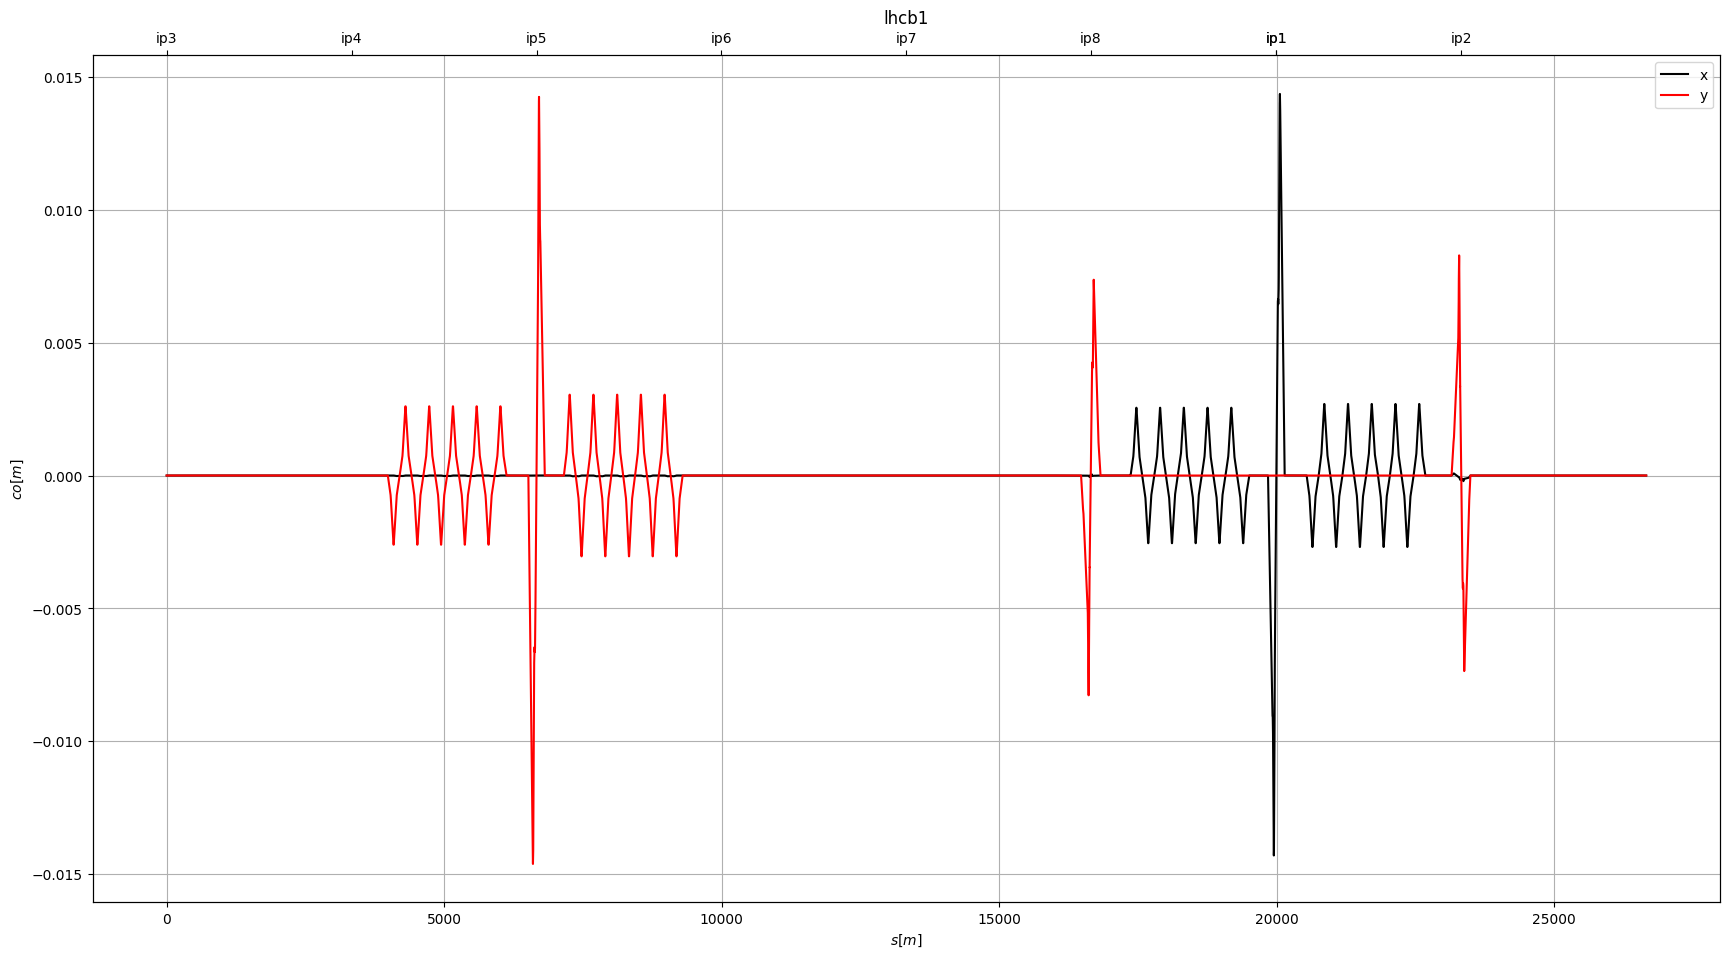

In [50]:
plot_orbit(collider, "lhcb1", twb1)

In [51]:
plot_orbit(collider, "lhcb2", twb2)

Reset the knobs that activate the crossing knobs

In [52]:
collider.varval["on_x1"] = 0
collider.varval["on_x5"] = 0
collider.varval["on_x2"] = 0
collider.varval["on_sep2"] = 0
collider.varval["on_x8v"] = 0
collider.varval["on_sep8h"] = 0
collider.varval["on_sep8v"] = 0

***NOTE: Not working properly***


Rematching of chromatic functions

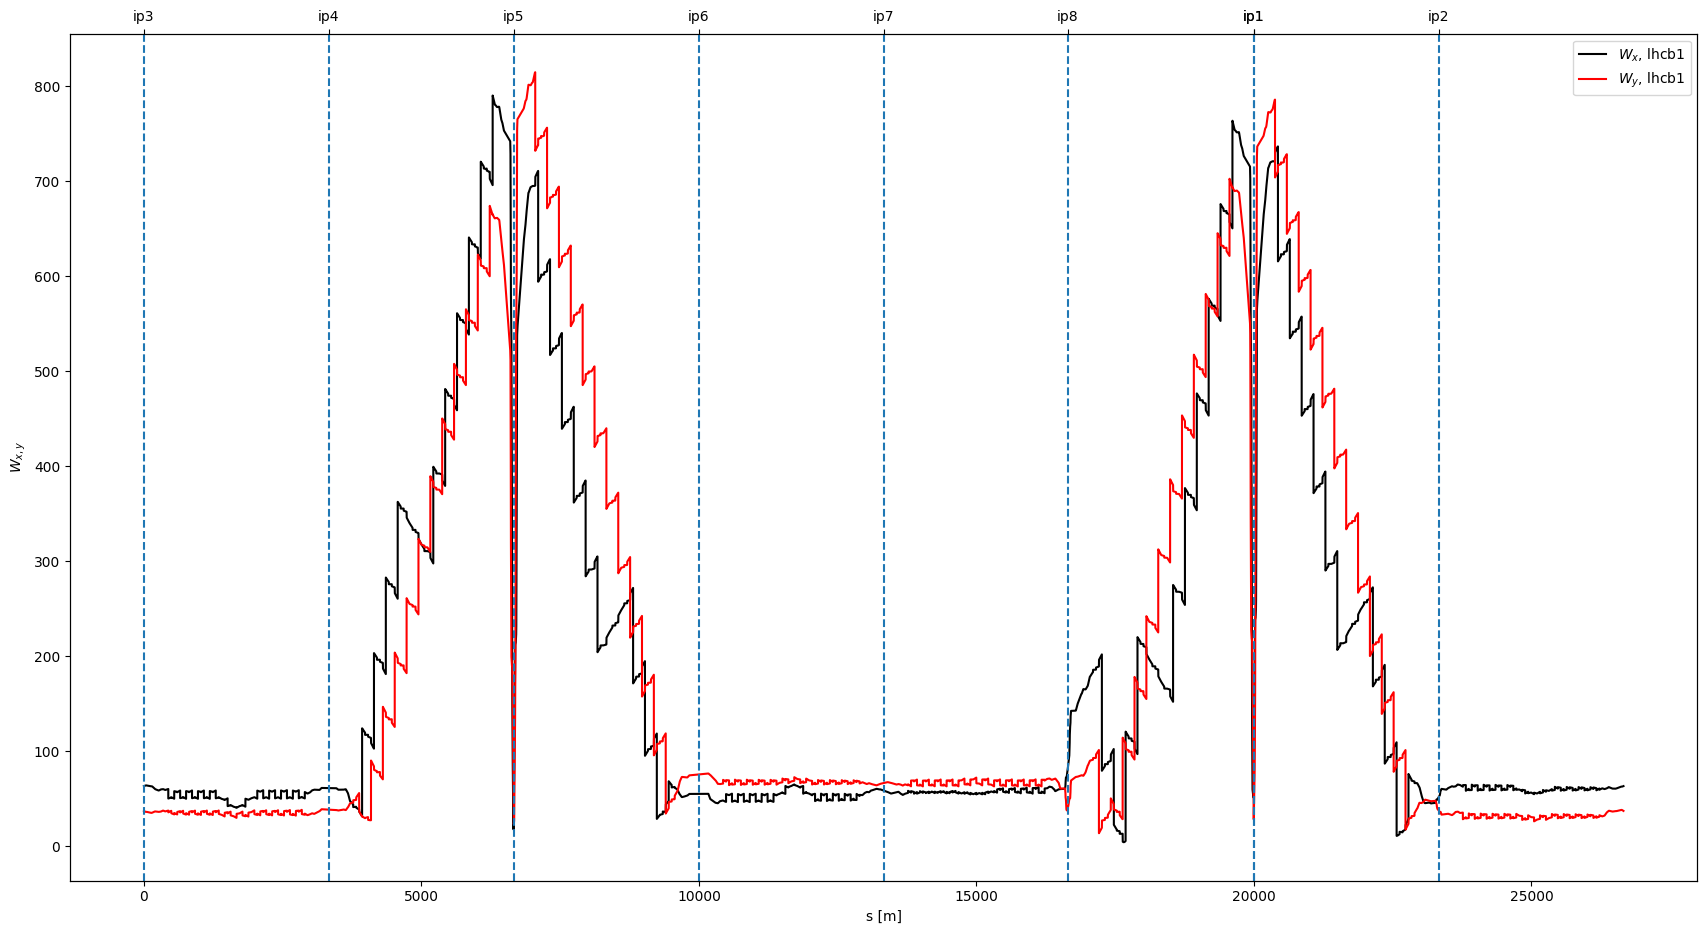

In [53]:
tw = collider["lhcb1"].cycle("ip3").twiss(method="4d")
plot_w(collider, 'lhcb1', tw)

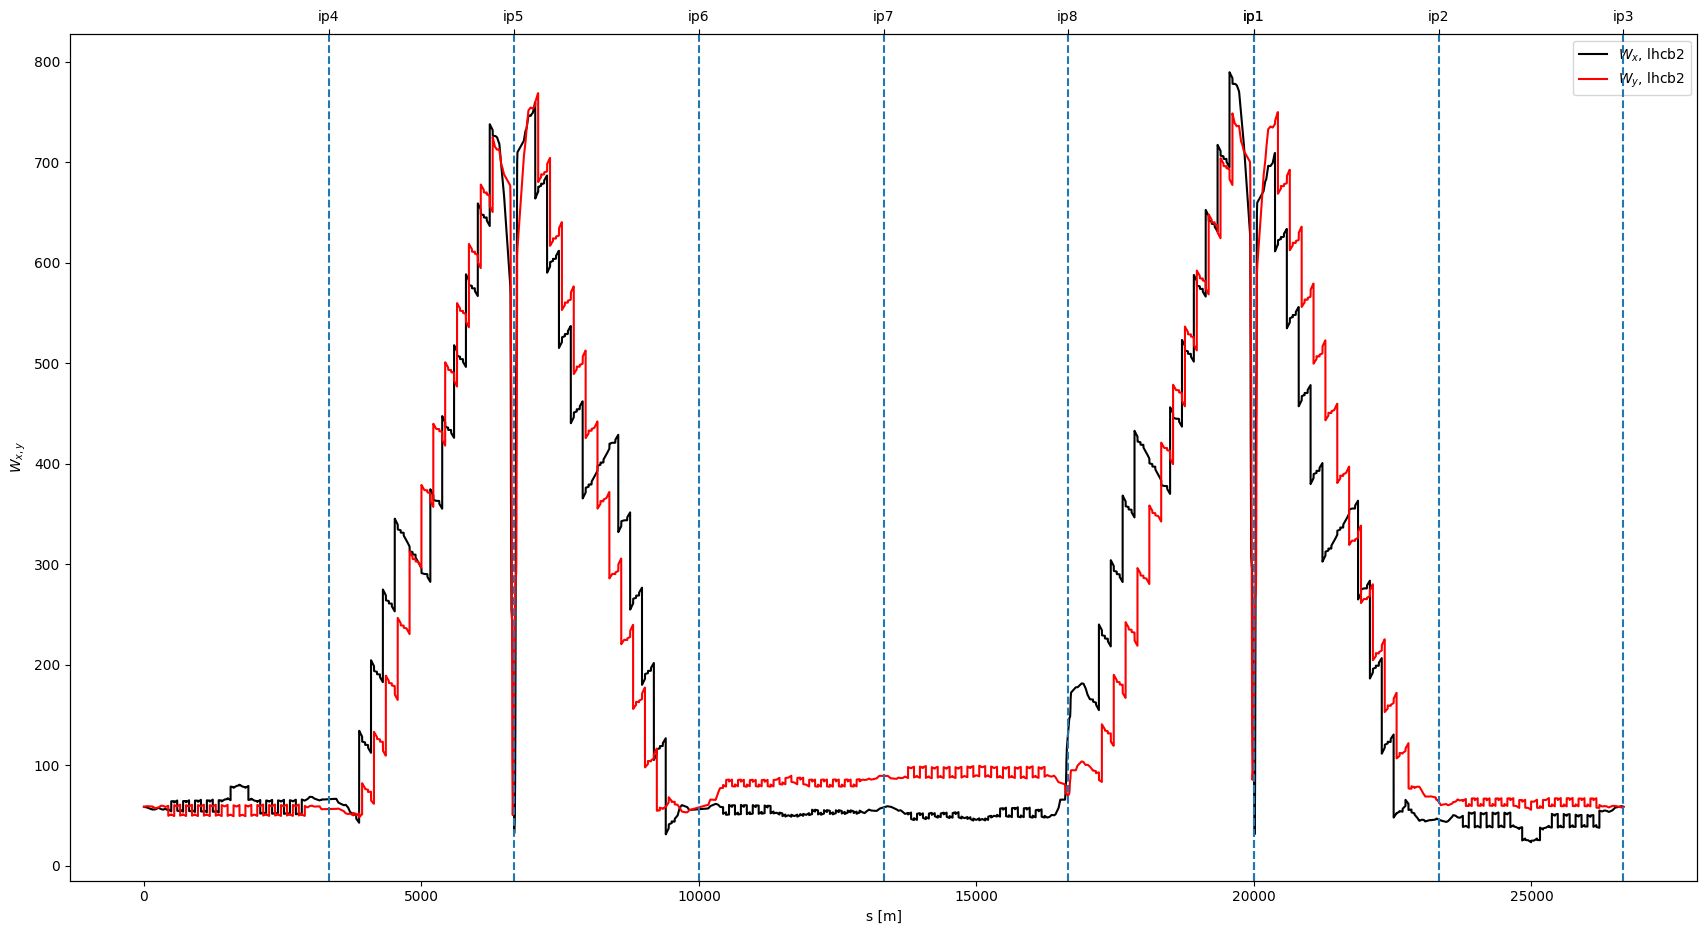

In [54]:
twb2 = collider["lhcb2"].cycle("ip3").twiss(method="4d", reverse=True)
plot_w(collider, 'lhcb2', twb2)

In [55]:
ksfd = {"b1": {"f": 0.06, "d": -0.099}, "b2": {"f": 0.06, "d": -0.099}}
set_sext_all(collider, ksfd)

In [56]:
opt_chromaweak = corchroma_weak(collider, 2)

Matching: model call n. 28       

Matching: model call n. 20       



In [57]:
opt_chromaweak[0].log()

Table: 8 rows, 14 cols
iteration     penalty alpha tag tol_met target_active hit_limits vary_active   vary_0    vary_1 ...
        0     326.531    -1     nn      yy            nn         yy                 0         0
        1     38.8596     0     nn      yy            nn         yy          0.279779 -0.532317
        2    0.517883     0     nn      yy            nn         yy           0.32553 -0.546468
        3   0.0211747     0     nn      yy            nn         yy          0.326123 -0.546653
        4  0.00162443     0     ny      yy            nn         yy          0.326146 -0.546661
        5 0.000179847     0     ny      yy            nn         yy          0.326148 -0.546661
        6 4.05479e-06     0     ny      yy            nn         yy          0.326148 -0.546661
        7 3.08426e-08     0     yy      yy            nn         yy          0.326148 -0.546661

In [58]:
opt_chromaweak[1].log()

Table: 6 rows, 14 cols
iteration     penalty alpha tag tol_met target_active hit_limits vary_active   vary_0    vary_1 ...
        0      326.34    -1     nn      yy            nn         yy                 0         0
        1    0.368251     0     nn      yy            nn         yy          0.322481  -0.54686
        2  0.00256646     0     ny      yy            nn         yy          0.322922 -0.547103
        3 0.000141417     0     ny      yy            nn         yy          0.322925 -0.547104
        4 3.54959e-06     0     ny      yy            nn         yy          0.322925 -0.547104
        5 1.12688e-07     0     yy      yy            nn         yy          0.322925 -0.547104

In [59]:
optimizers["opt_w_b1"] =  rematch_w(collider, "lhcb1", solve=True)

Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack_backtrack`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
tar_ix1=21.55618673587462
tar_iy1=21.556180363351828
tar_ix5=21.55618884330967
tar_iy5=21.55617414387884
Matching: model call n. 42       

Could not find point within tolerance.




In [60]:
optimizers["opt_w_b1"].log()

Table: 5 rows, 34 cols
iteration penalty alpha tag tol_met          target_active    hit_limits vary_active   vary_0 ...
        0 3273.33    -1     nnnnnnnnnnnnnnnn yyyyyyyyyyyyyyyy nnnnnnnn   yyyyyyyy        0.06
        1 1180.24     0     nnnnnnnnnnnnnnnn yyyyyyyyyyyyyyyy nynnnnny   yyyyyyyy    0.277929
        2 1171.68     0     nnnnnnnnnnnnnnnn yyyyyyyyyyyyyyyy nnnynynn   yyyyyyyy    0.250029
        3 589.111     1     nnnnnnnnnnnnnnnn yyyyyyyyyyyyyyyy nnnnnnnn   yyyyyyyy    0.263994
        4 301.441     1     nnnnnnnnnnnnnnnn yyyyyyyyyyyyyyyy nnnnnnnn   yyyyyyyy    0.270943

In [61]:
optimizers["opt_w_b2"] =  rematch_w(collider, "lhcb2", solve=True)

Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
tar_ix1=21.556182349571905
tar_iy1=21.556180705589732
tar_ix5=21.556186190622434
tar_iy5=21.556183338723443
Matching: model call n. 42       

Could not find point within tolerance.




In [62]:
optimizers["opt_w_b2"].log()

Table: 5 rows, 34 cols
iteration penalty alpha tag tol_met          target_active    hit_limits vary_active   vary_0 ...
        0  2823.9    -1     nnnnnnnnnnnnnnnn yyyyyyyyyyyyyyyy nnnnnnnn   yyyyyyyy        0.06
        1 885.137     0     nnnnnnnnnnnnnnnn yyyyyyyyyyyyyyyy nnnnnynn   yyyyyyyy    0.172303
        2 880.832     0     nnnnnnnnnnnnnnnn yyyyyyyyyyyyyyyy nynynnny   yyyyyyyy    0.172511
        3  465.16     1     nnnnnnnnnnnnnnnn yyyyyyyyyyyyyyyy nnnnnnnn   yyyyyyyy    0.172189
        4 276.973     1     nnnnnnnnnnnnnnnn yyyyyyyyyyyyyyyy nnnnnnnn   yyyyyyyy    0.172027

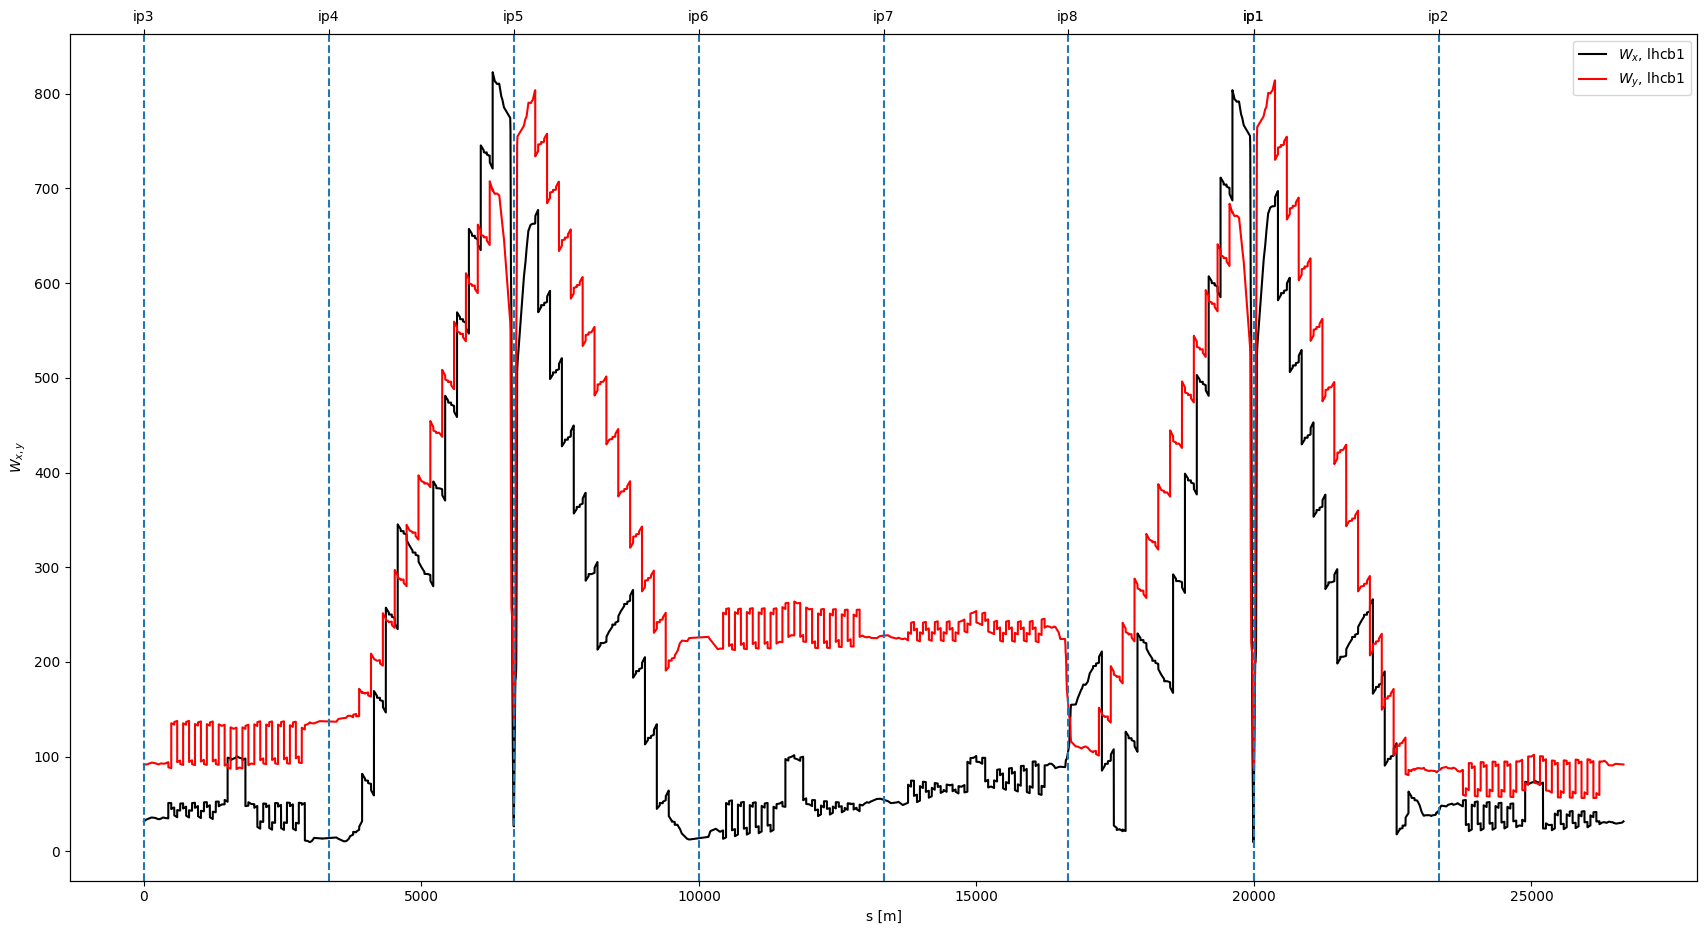

In [63]:
tw_new_w = collider["lhcb1"].cycle("ip3").twiss(method="4d")
plot_w(collider, "lhcb1", tw_new_w)

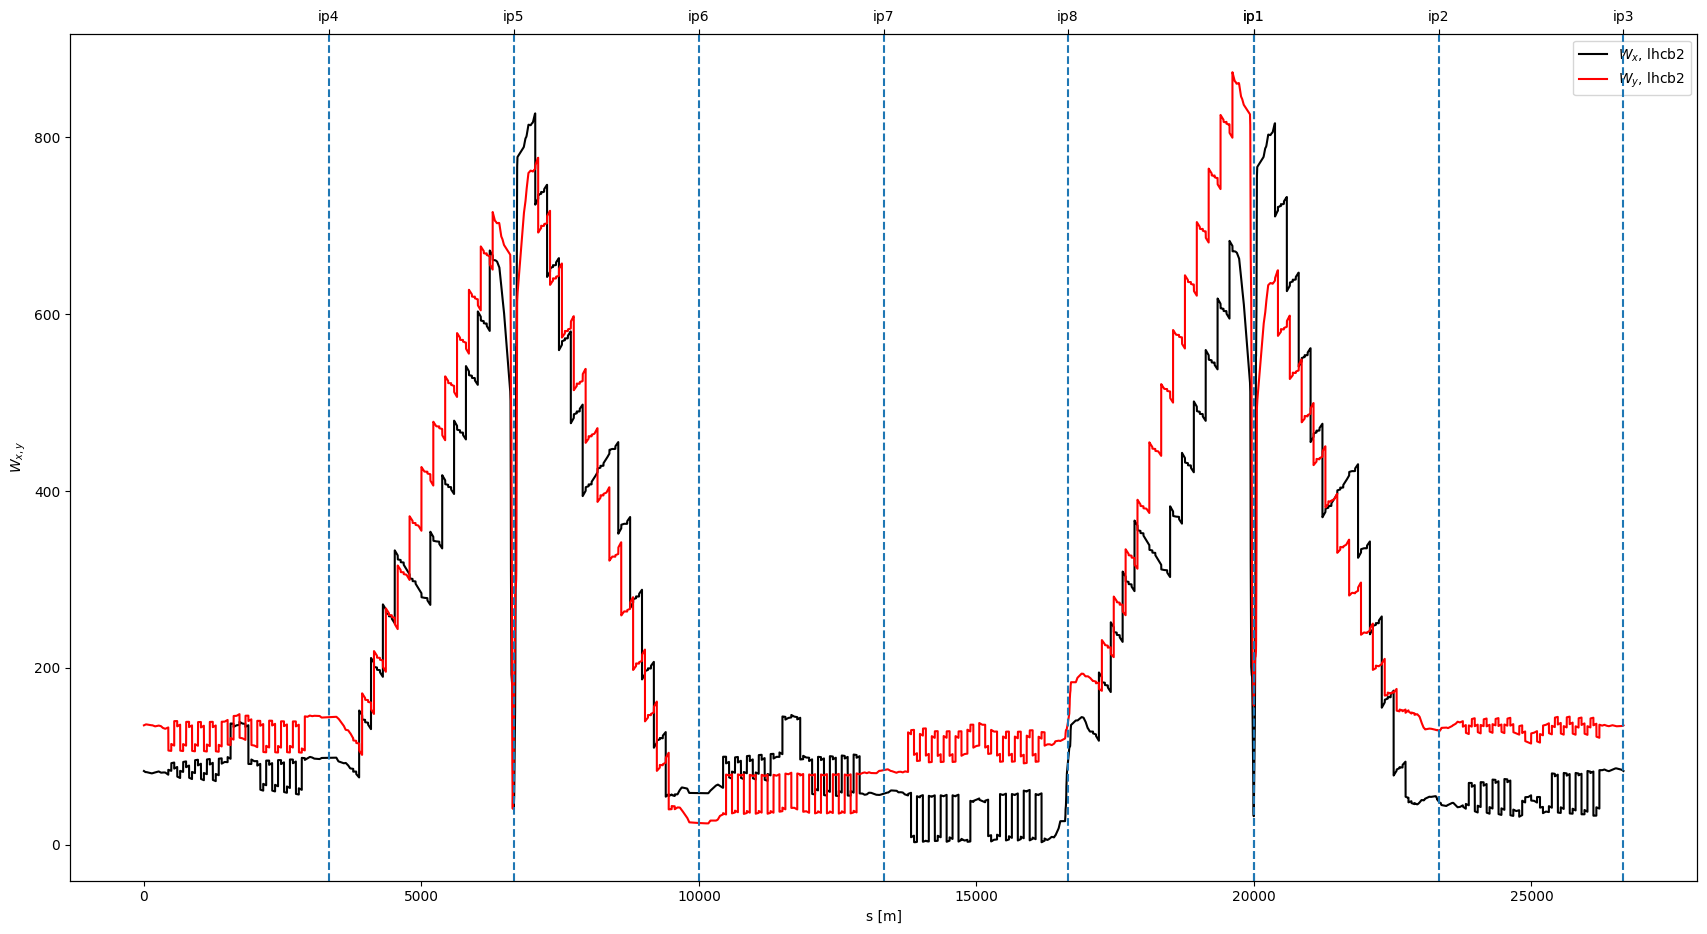

In [64]:
tw_new_wb2 = collider["lhcb2"].cycle("ip3").twiss(method="4d", reverse=True)
plot_w(collider, "lhcb2", tw_new_wb2)

In [65]:
opt_chromaweak = corchroma_weak(collider, 2)

Matching: model call n. 28       

Matching: model call n. 24       



In [66]:
opt_chromaweak[0].log()

Table: 8 rows, 14 cols
iteration     penalty alpha tag tol_met target_active hit_limits vary_active    vary_0   vary_1 ...
        0      300.72    -1     nn      yy            nn         yy                  0        0
        1      28.769     0     nn      yy            nn         yy          -0.355222 0.476333
        2     2.04929     0     nn      yy            nn         yy          -0.318368 0.464909
        3    0.164664     0     nn      yy            nn         yy          -0.321015 0.465723
        4  0.00855869     0     nn      yy            nn         yy          -0.320828 0.465665
        5 0.000158071     0     ny      yy            nn         yy          -0.320818 0.465662
        6 1.32624e-06     0     ny      yy            nn         yy          -0.320818 0.465662
        7 1.14464e-07     0     yy      yy            nn         yy          -0.320818 0.465662

In [67]:
opt_chromaweak[1].log()

Table: 7 rows, 14 cols
iteration     penalty alpha tag tol_met target_active hit_limits vary_active    vary_0   vary_1 ...
        0     275.027    -1     nn      yy            nn         yy                  0        0
        1     24.9225     0     nn      yy            nn         yy          -0.302525 0.470428
        2      1.5911     0     nn      yy            nn         yy             -0.271 0.460686
        3    0.190618     0     nn      yy            nn         yy          -0.273118 0.461337
        4  0.00802037     0     nn      yy            nn         yy          -0.272882 0.461263
        5 2.02945e-05     0     ny      yy            nn         yy          -0.272892 0.461266
        6 4.41465e-07     0     yy      yy            nn         yy          -0.272892 0.461266

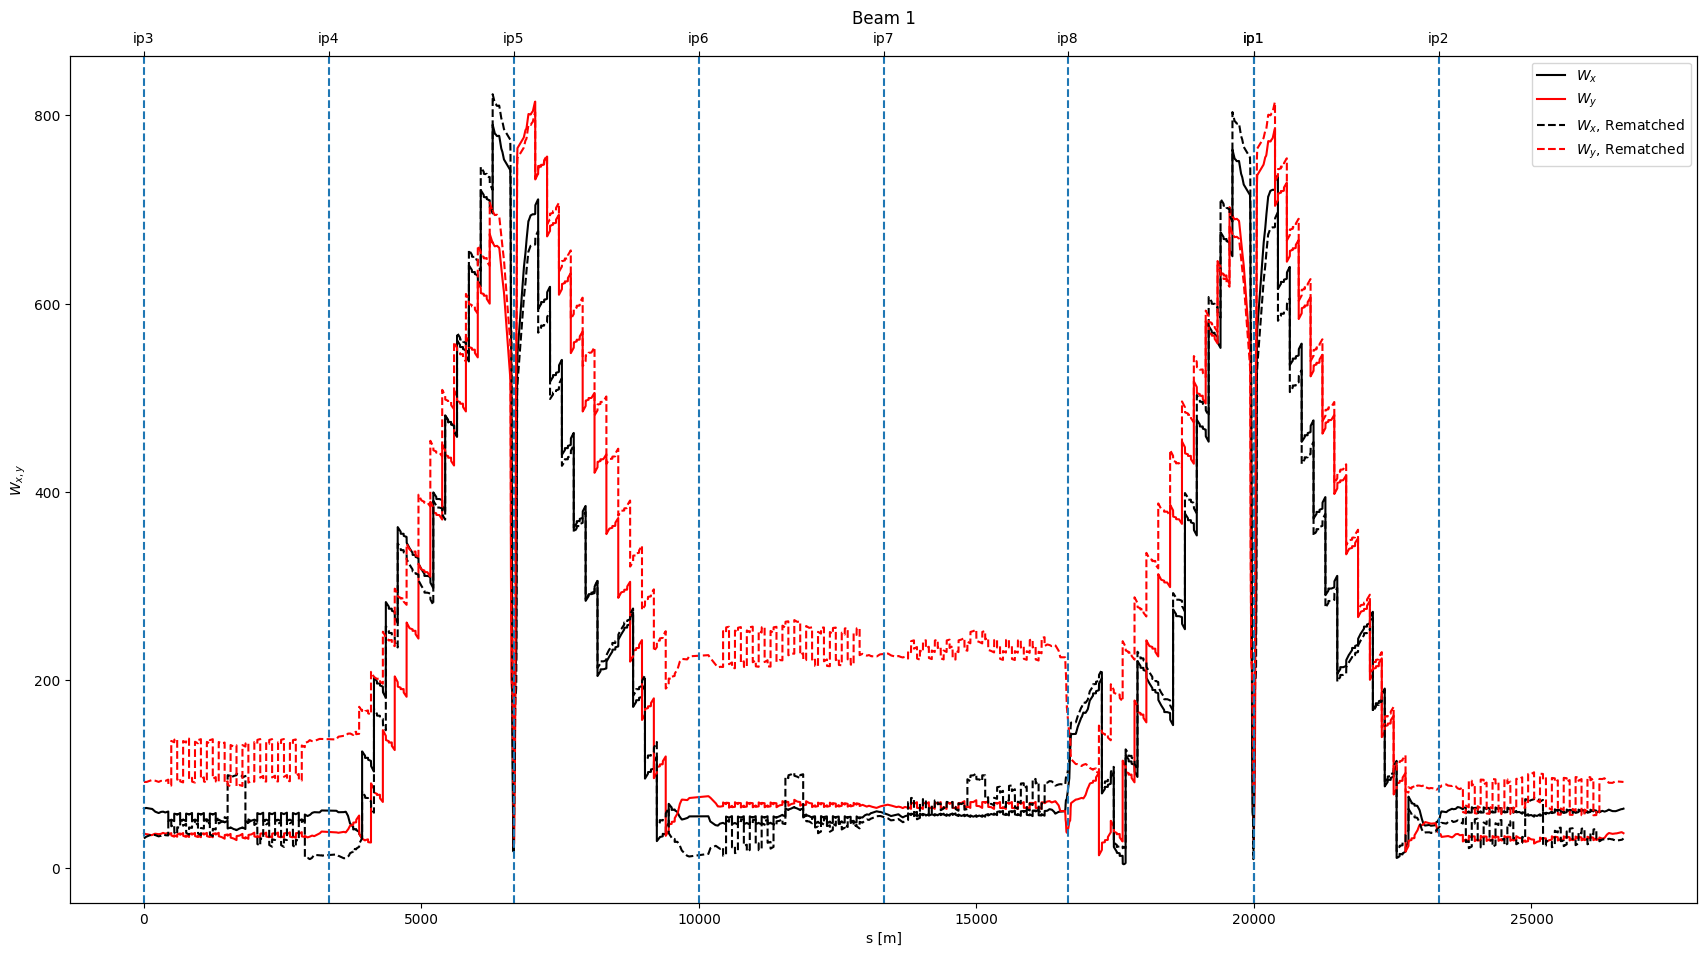

In [68]:
fig, axs = plt.subplots(figsize=(21, 11))
axs.set_title("Beam 1")
axs.plot(tw.s, tw.wx_chrom, label=r"$W_x$", color="black")
axs.plot(tw.s, tw.wy_chrom, label=r"$W_y$", color="red")
axs.plot(tw_new_w.s, tw_new_w.wx_chrom, label=r"$W_x$, Rematched", color="black", ls='--')
axs.plot(tw_new_w.s, tw_new_w.wy_chrom, label=r"$W_y$, Rematched", color="red", ls='--')

axs_t = axs.twiny()
axs_t.set_xticks(tw[["s"], "ip.*"], tw[["name"], "ip.*"])
axs_t.set_xlim(axs.get_xlim())
[axs_t.axvline(xpos, linestyle="--") for xpos in tw[["s"], "ip.*"]]
axs.set_xlabel("s [m]")
axs.set_ylabel(r"$W_{x,y}$")
axs.legend()
plt.show()

In [69]:
fig, axs = plt.subplots(figsize=(21, 11))
axs.set_title("Beam 2")
axs.plot(twb2.s, twb2.wx_chrom, label=r"$W_x$", color="black")
axs.plot(twb2.s, twb2.wy_chrom, label=r"$W_y$", color="red")
axs.plot(tw_new_wb2.s, tw_new_wb2.wx_chrom, label=r"$W_x$, Rematched", color="black", ls='--')
axs.plot(tw_new_wb2.s, tw_new_wb2.wy_chrom, label=r"$W_y$, Rematched", color="red", ls='--')

axs_t = axs.twiny()
axs_t.set_xticks(tw[["s"], "ip.*"], tw[["name"], "ip.*"])
axs_t.set_xlim(axs.get_xlim())
[axs_t.axvline(xpos, linestyle="--") for xpos in tw[["s"], "ip.*"]]
axs.set_xlabel("s [m]")
axs.set_ylabel(r"$W_{x,y}$")
axs.legend()
plt.show()

In [70]:
nrj = 7000
z_crab = 1e-3
optimizers["crab_cavities"], crabh_angle_max, crabv_angle_max = rematch_crabs(
    collider, reset_values=True
)
print(f"{crabh_angle_max=}, {crabv_angle_max=}")

Matching: model call n. 28       

Matching: model call n. 32       

Matching: model call n. 45       

Matching: model call n. 24       

Matching: model call n. 8       

Matching: model call n. 8       

Matching: model call n. 8       

Matching: model call n. 8       

-380.1822395199423 -380.1969475272043
-380.0842710714291 -380.4656470588925
-402.5715259593485 -388.5908265256633
-388.3188121189802 -402.6758723049863
-380.4723322585603 -380.99634915638444
-380.8839986709258 -380.7553505906843
-401.7797720550237 -388.30545847909565
-388.03303333257634 -401.8844023052764
crabh_angle_max=380.0842710714291, crabv_angle_max=380.1969475272043
crabh_angle_max=380.0842710714291, crabv_angle_max=380.1969475272043


In [71]:
tune_chroma_targets = {
    "b1": {"qx": 62.31, "qy": 60.32, "dqx": 2, "dqy": 2},
    "b2": {"qx": 62.31, "qy": 60.32, "dqx": 2, "dqy": 2},
}

In [72]:
optimizers["tune"] = rematch_tune(collider, tune_chroma_targets, solve=True)
print(optimizers["tune"]["b1"].log())
print(optimizers["tune"]["b2"].log())

Matching: model call n. 1       

Matching: model call n. 1       

Table: 2 rows, 14 cols
iteration     penalty alpha tag tol_met target_active hit_limits vary_active vary_0 vary_1 ...
        0 7.06351e-07    -1     yy      yy            nn         yy               0      0
        1 7.06351e-07  None     yy      yy            nn         yy               0      0
Table: 2 rows, 14 cols
iteration     penalty alpha tag tol_met target_active hit_limits vary_active vary_0 vary_1 ...
        0 1.20344e-06    -1     yy      yy            nn         yy               0      0
        1 1.20344e-06  None     yy      yy            nn         yy               0      0


In [73]:
optimizers["chroma"] = rematch_chroma(collider, tune_chroma_targets, solve=True)
print(optimizers["chroma"]["b1"].log())
print(optimizers["chroma"]["b2"].log())

Matching: model call n. 1       

Matching: model call n. 1       

Table: 2 rows, 14 cols
iteration     penalty alpha tag tol_met target_active hit_limits vary_active vary_0 vary_1 ...
        0 1.14464e-07    -1     yy      yy            nn         yy               0      0
        1 1.14464e-07  None     yy      yy            nn         yy               0      0
Table: 2 rows, 14 cols
iteration     penalty alpha tag tol_met target_active hit_limits vary_active vary_0 vary_1 ...
        0 4.41465e-07    -1     yy      yy            nn         yy               0      0
        1 4.41465e-07  None     yy      yy            nn         yy               0      0
